In [1]:
# 필요한 패키지를 불러옵니다.
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import skew, kurtosis

# Model

In [2]:
# Poisson Thinning 연산자 함수를 생성합니다.
def PT(alpha,X):
    N=np.random.poisson(alpha,X)
    Y=sum(N)
    return Y

In [3]:
def INHAR_P(hps,params,n):
    X0=list(np.random.poisson(params[-1],hps[-1])) # 초기 값 생성
    for t in range(hps[-1],n):
        order,Y=[],[]
        for i in hps:
            globals()['Xt_{}'.format(i)] = int(np.mean(X0[t-i:t])) # X_{t-1}^{(i)} 생성
            order.append(globals()['Xt_{}'.format(i)])
        for i in range(len(hps)):
            Xt=PT(params[i],order[i]) # alpha와 h_i 이동평균으로 PT 연산자 계산
            Y.append(Xt)
        lamb=np.random.poisson(params[-1]) # 파라미터 lambda를 가진 오차항 생성
        Y=sum(Y)+lamb
        X0.append(Y)
    return X0

In [4]:
def INHAR(X,hps): # Data -> INHAR
    Y,XX=[],[]
    for t in range(hps[-1],len(X)):
        Xt=X[t]
        order=[]
        for i in hps:
            globals()['Xt_'+str(i)] = int(np.mean(X[t-i:t]))
            order.append(globals()['Xt_'+str(i)])
        XX.append(order+[1])
        Y.append(Xt)
    return np.array(XX), np.array(Y)

In [5]:
def CLSE(data,hps): # CLS Estimator
    nn,p=len(data),len(hps)
    for i in range(p+1):
        globals()['b_'+str(i)] = 0 # b 초기값 생성
    A=np.zeros((p+1,p+1)) # A 초기값 행렬 생성
    for t in range(nn-hps[-1]):
        Xt=data[t+hps[-1]] # X_t
        Xtt=[] # X_{t-1}^{(i)}
        for i in hps:
            globals()['Xt_'+str(i)] = int(np.mean(data[t+hps[-1]-i : t+hps[-1]]))
            Xtt.append(globals()['Xt_'+str(i)])
        Xtt.append(1) # [X_{t-1}^{(1)},...,X_{t-1}^{(p)},1]
        for i in range(p+1):
            globals()['b_'+str(i)] = globals()['b_'+str(i)] + Xt*Xtt[i] # sum: X_t*X_{t-1}^{(1)}, ..., X_t*1
            for j in range(p+1):
                A[i,j]=A[i,j]+Xtt[i]*Xtt[j]
    b=[]
    for i in range(p+1):
        b.append(globals()['b_'+str(i)])
    A_inv=np.linalg.inv(A)
    return np.matmul(A_inv,b) # A^{-1}*b

In [6]:
def YWE(data,hps): # Yule-Walker Estimator
    his=[0,*hps]
    beta=sm.regression.linear_model.yule_walker(data,his[-1],"mle")[0] # beta 계산
    a_h,ayw=0,[] # sum: alpha_l/h_l 초기값 0 
    for i in reversed(range(1,len(his))):
        globals()['a_'+str(i)] = his[i]*(sum(beta[his[i-1]:his[i]])/(his[i]-his[i-1])-a_h)
        a_h = a_h + globals()['a_'+str(i)]/his[i]
        ayw.append(globals()['a_'+str(i)])
    ayw.reverse()
    X,Y=INHAR(data,hps)
    lamb=np.mean([Y[t]-sum(np.array(ayw)*X[t][:len(hps)]) for t in range(len(Y))])
    return np.array([*ayw,lamb])

In [7]:
hps=[1,7]
params=[0.4,0.25,1]
inhar=INHAR_P(hps,params,1000)

In [8]:
CLSE(inhar,hps)

array([0.38057653, 0.37404148, 0.77356126])

In [9]:
YWE(inhar,hps)

array([0.37491011, 0.37998496, 0.7754316 ])

In [10]:
hps=[1,3,6,9]
params=[0.4,0.2,0.1,0.05,1]
inhar=INHAR_P(hps,params,1000)

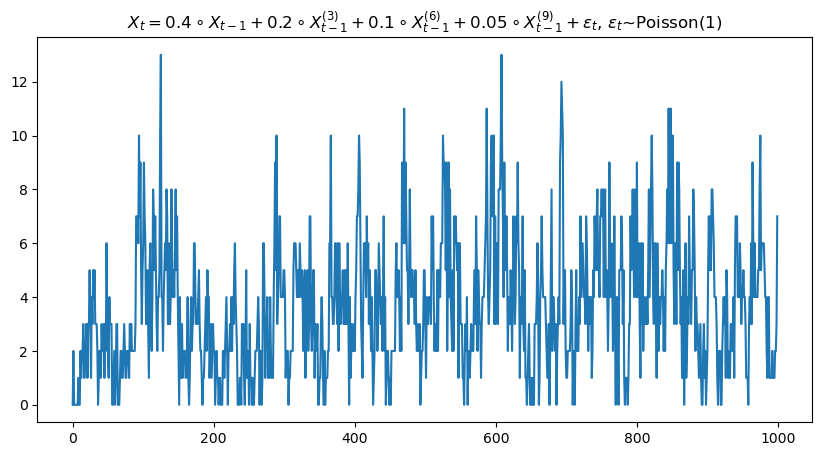

In [11]:
plt.figure(figsize=(10,5))
plt.title("$X_t=0.4\circ X_{t-1}+0.2\circ X_{t-1}^{(3)}+0.1\circ X_{t-1}^{(6)}+0.05\circ X_{t-1}^{(9)}+\epsilon_t$, $\epsilon_t$~Poisson(1)")
plt.plot(inhar);

# EDA

In [12]:
data=pd.read_excel('data/ipo.xlsx')
data.set_index('period',inplace=True)
data=data.transpose()
data.head()

period,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월
2022,4,13,8,7,3,10,7,0,0,0,0,0
2021,6,11,10,6,9,6,4,8,10,11,11,8
2020,2,4,7,0,2,6,15,9,11,6,6,18
2019,2,3,7,1,8,6,10,12,5,12,14,17
2018,2,8,3,2,4,4,6,9,5,7,18,22


In [13]:
ipo=[]
[ipo.extend(data.values[_]) for _ in reversed(range(len(data)))]
ipo=ipo[:-5]

In [14]:
Date=pd.date_range("2000-1","2022-7",freq="MS")

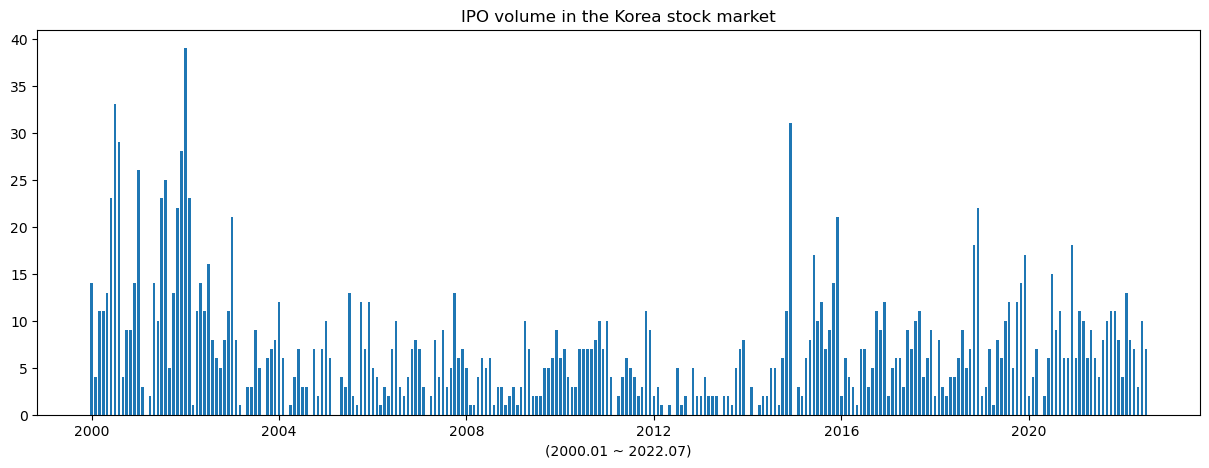

In [15]:
plt.figure(figsize=(15,5))
plt.title("IPO volume in the Korea stock market")
plt.xlabel("(2000.01 ~ 2022.07)")
plt.bar(Date,ipo,width=20);

In [16]:
pd.DataFrame(ipo).describe()

,0
count,271.000000
mean,6.830258
std,6.103488
min,0.000000
25%,3.000000
50%,6.000000
75%,9.000000
max,39.000000


In [17]:
skew(ipo), kurtosis(ipo, fisher=True)

(1.984983657859022, 5.407857417918768)

In [18]:
result=adfuller(ipo)
print('ADF statistics: %f' % result[0])
print('p-value: %f' % result[1])

ADF statistics: -2.914398
p-value: 0.043699


# Fitting

In [19]:
hps=[1,6,12]
X,Y=INHAR(ipo,hps)
model=sm.OLS(Y,X) # CLS는 OLS의 변형
results=model.fit()

In [20]:
results.params, results.bse

(array([0.3068645 , 0.11411933, 0.34422379, 1.64111388]),
 array([0.06670837, 0.18403586, 0.18617397, 0.65643034]))

In [21]:
CLSE(ipo,hps), YWE(ipo,hps)

(array([0.3068645 , 0.11411933, 0.34422379, 1.64111388]),
 array([0.3024684 , 0.19810951, 0.34038671, 1.17824317]))

In [22]:
Y_pred=[np.matmul(YWE(ipo,hps),X[_]) for _ in range(len(X))]

In [23]:
res=np.array(Y)-Y_pred
tr_H=np.trace(X@np.linalg.inv(X.T@X)@X.T)
sigma_e=sum(res**2)/(len(X)-tr_H)

In [24]:
np.sqrt(np.diag(sigma_e*np.linalg.inv(X.T@X)))

array([0.06681683, 0.18433506, 0.18647666, 0.65749757])

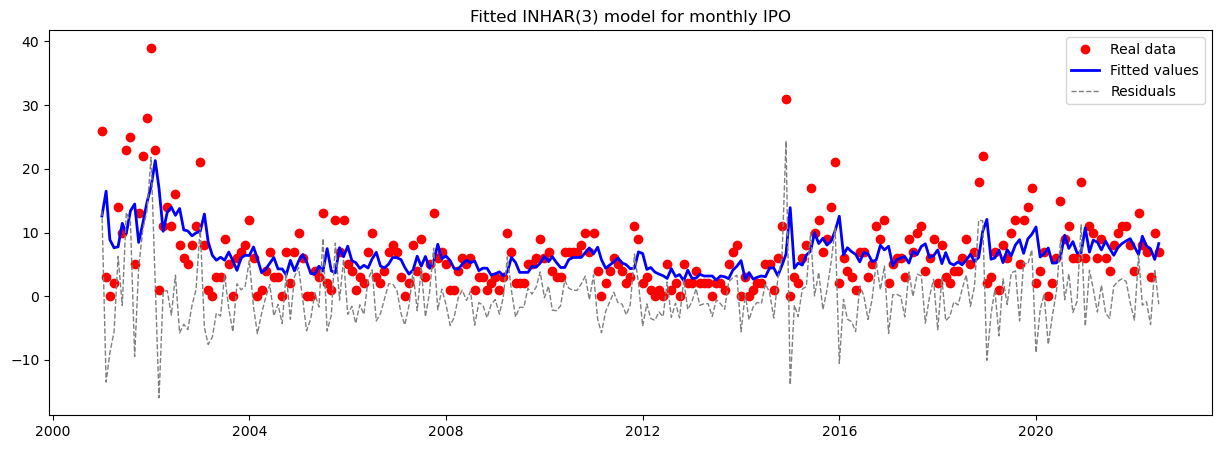

In [25]:
st=hps[-1]
plt.figure(figsize=(15,5))
plt.title(f"Fitted INHAR({len(hps)}) model for monthly IPO")
plt.plot(Date[st:],ipo[st:],color='r',linewidth=0,label="Real data",marker='o')
plt.plot(Date[st:],results.fittedvalues,color='b',linewidth=2,label="Fitted values")
plt.plot(Date[st:],results.resid,color='grey',linestyle='dashed',linewidth=1,label="Residuals")
plt.legend();

# Forecasting

In [26]:
def INHAR_FORE(data,hps,m,n,method):
    if method=="CLS":
        F,F_cl,F_cu=[],[],[]
        for i in range(n):
            X,Y=INHAR(data[-m+i:-n+i],hps)
            model=sm.OLS(Y,X)
            results=model.fit()
            clse=results.params
            clse_cl=np.array([results.conf_int()[_][0] for _ in range(len(hps)+1)])
            clse_cu=np.array([results.conf_int()[_][1] for _ in range(len(hps)+1)])
            y,y_cl,y_cu=sum(clse*X[-1]),sum(clse_cl*X[-1]),sum(clse_cu*X[-1])
            F.append(y)
            F_cl.append(y_cl)
            F_cu.append(y_cu)
        res=np.array(F)-data[-n:]
        F_cls=[F,F_cl,F_cu]
        return res,F_cls
    
    elif method=="YW":
        F_yw=[]
        for i in range(n):
            ywe=YWE(data[-m+i:-n+i],hps)
            X,Y=INHAR(data[-m+i:-n+i],hps)
            y=sum(ywe*X[-1])
            F_yw.append(y)
        res=np.array(F_yw)-data[-n:]
        return res,F_yw  
    else:
        raise NotImplementedError

In [27]:
m,n=len(ipo),19
hps=[1,6,12]
res,fore=INHAR_FORE(ipo,hps,m,n,"CLS")
F,F_cl,F_cu=fore
# res,F=INHAR_FORE(ipo,hps,m,n,"YW")

In [28]:
def PM(data,res,F): # Performance Measures
    mae=sum(abs(res))/len(res)
    rmse=np.sqrt(sum(res**2)/len(res))
    mape=sum(abs(res/data[-n:]))*100/len(res)
    smape=sum(abs(res)/(data[-n:]+abs(np.array(F))))*100/len(res)
    rrse=np.sqrt(sum(res**2)/sum((np.mean(data[-n:])-data[-n:])**2))
    return mae,rmse,mape,smape,rrse

In [29]:
PM(ipo,res,F)

(2.489652723795447,
 2.974301653176356,
 39.18584216933609,
 16.715254449608565,
 1.1117121670359502)

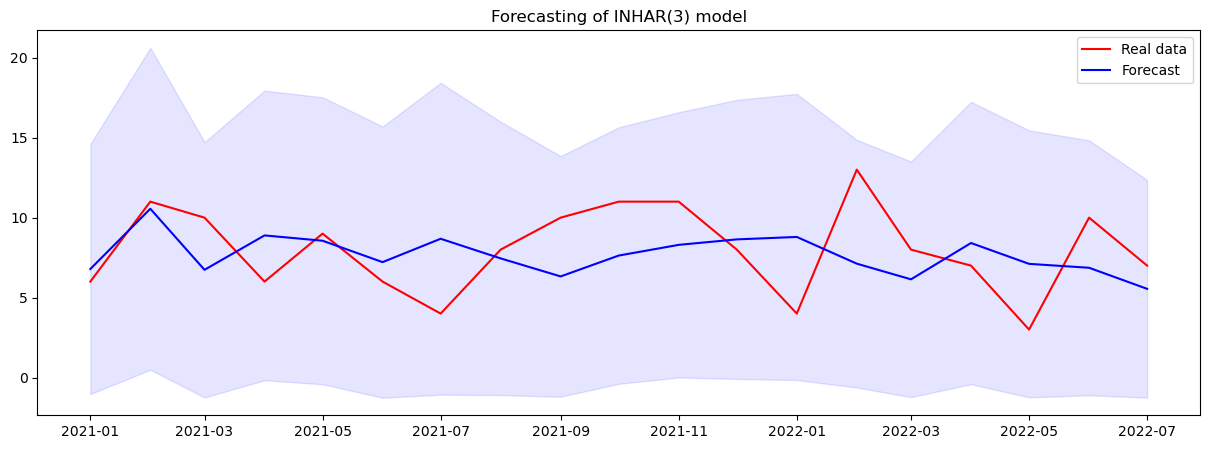

In [30]:
fig, ax = plt.subplots(figsize=(15,5))
plt.title(f"Forecasting of INHAR({len(hps)}) model")
ax.plot(Date[-n:],ipo[-n:],label="Real data",color='r')
ax.plot(Date[-n:],F,label="Forecast",color='b')
ax.fill_between(Date[-n:],F_cl,F_cu, color='b', alpha=.1)
plt.legend();

In [31]:
def INAR(X,p):
    Y,XX=[],[]
    for t in range(p,len(X)):
        Xt=X[t]
        order=[]
        for i in range(p):
            order.append(int(X[t-(i+1)]))
        XX.append(order+[1])
        Y.append(Xt)
    return XX,Y

In [32]:
def INAR_FORE(data,p,m,n,method):
    if method=="CLS":
        F_cls=[]
        for i in range(n):
            X,Y=INAR(data[-m+i:-n+i],p)
            model=sm.OLS(Y,X)
            results=model.fit()
            clse=results.params
            y=sum(clse*X[-1])
            F_cls.append(y)
        res=np.array(F_cls)-data[-n:]
        return res,F_cls
    
    elif method=="YW":
        F_yw=[]
        for i in range(n):
            params=[]
            beta=sm.regression.linear_model.yule_walker(data[-m+i:-n+i],order=p,method="mle")[0]
            for j in range(p):
                params.append(beta[j])
            X,Y=INAR(data[-m+i:-n+i],p)
            lamb=np.mean([Y[_]-sum(np.array(params)*X[_][:p]) for _ in range(len(Y))])
            ywe=np.array(params+[lamb])
            y=sum(ywe*X[-1])
            F_yw.append(y)
        res=np.array(F_yw)-data[-n:]
        return res,F_yw
    else:
        raise NotImplementedError

In [33]:
m,n,p=len(ipo),19,3
res,F=INAR_FORE(ipo,p,m,n,"CLS")

In [34]:
PM(ipo,res,F)

(2.80061009910907,
 3.1743595092409542,
 41.32651112832314,
 18.841564504552334,
 1.1864882922015416)

# Efficiency

In [35]:
m,n,p=len(ipo),19,3
hps=[1,6,12]
method="CLS"

inar_res,inar_F=INAR_FORE(ipo,p,m,n,method)
inhar_res,inhar_F=INHAR_FORE(ipo,hps,m,n,method)

In [36]:
inar_pm=PM(ipo,inar_res,inar_F)
inhar_pm=PM(ipo,inhar_res,inhar_F[0]) # CLS
# inhar_pm=PM(ipo,inhar_res,inhar_F) # YW

In [37]:
(np.array(inar_pm)-inhar_pm)/inhar_pm*100

array([12.48998996,  6.72621272,  5.46286322, 12.72077587,  6.72621272])